# Window-Based Detection using KAZE Descriptor Featuring Matching

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV
import pickle as pkl

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from dataset import *
from descriptor import *
from SlidingWindow import *
from BagOfWords import *

In [2]:
# Global Variables
run_sliding_window = False

curr_wd = os.getcwd()
example_path = os.path.join(curr_wd, 'Image Templates/', 'waldo_template_1.jpg')
example_full_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '000.jpg')
train_annot_path = os.path.join(curr_wd, 'cache_anno/', 'train_annots.pkl')

# Paths for training data
goal_dir = os.path.join(curr_wd, 'datasets')
train_waldo_dir = os.path.join(goal_dir, 'train', 'positives', 'waldo')
val_waldo_dir = os.path.join(goal_dir, 'val', 'positives', 'waldo')
extra_waldo_dir = os.path.join(goal_dir, 'extra', 'positives', 'waldo')
confusion_waldo_dir = os.path.join(goal_dir, 'extra', 'positives', 'waldo')
confusion_waldo_dir = os.path.join(goal_dir, 'extra', 'confusion', 'waldo_wenda')
front_waldo_dir = os.path.join(goal_dir, 'waldo_extra', 'front')
side_waldo_dir = os.path.join(goal_dir, 'waldo_extra', 'side')
tilt_waldo_dir = os.path.join(goal_dir, 'waldo_extra', 'tilt')

with open(train_annot_path, 'rb') as f:
    train_annots = pickle.load(f)

## Sliding Window

In order to perform window based detection on an image, we need to construct a sliding window subroutine in order to iterate over windows in an image. In the following demonstration, a multiscale sliding window routine using image pyramids is displayed

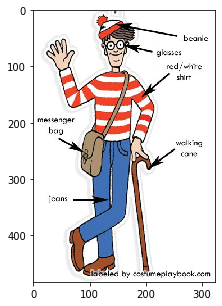

In [3]:
# Load example image 
example_image = plt.imread(example_path)
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.imshow(example_image)

In [4]:
# Sliding window routine
window_size = (100, 100)
if run_sliding_window: # Toggle demo using this variable
    for sub_image in image_pyramid(example_image, scale=1.5):
        for coordinates, window in sliding_window(sub_image, step_size=100, window_size=window_size):
            # NOTE: Can apply sub routine to process each image here

            # Extract coordinates of current bounding box
            y, x, y_end, x_end = coordinates

            sub_image_copy = sub_image.copy() 
            cv2.rectangle(sub_image_copy, (x, y), (x_end, y_end), (0, 255, 0), 2)
            cv2.imshow("Example", sub_image_copy)
            cv2.waitKey(1)
            time.sleep(0.025)

# NOTE: Running this cell block may crash the kernel. Only do so to visualise the results of sliding window

### Load Dataset

Loads the patches from the `datasets/train/positives` and `datasets/train/extra` as training data for classifier model. The patches are in the type `ndarray`

In [5]:
# Load data
detection_class = 'waldo'
train_pos, val_pos, train_neg, val_neg = prepare_dataloader(detection_class) # Returns generators for each set
train_pos, val_pos, train_neg, val_neg = list(train_pos), list(val_pos), list(train_neg), list(val_neg)
print('Positive Training Examples: ', len(train_pos))
print('Negative Training Examples: ', len(train_neg))

Positive Training Examples:  184
Negative Training Examples:  262


Text(0.5, 1.0, 'RGB Converted')

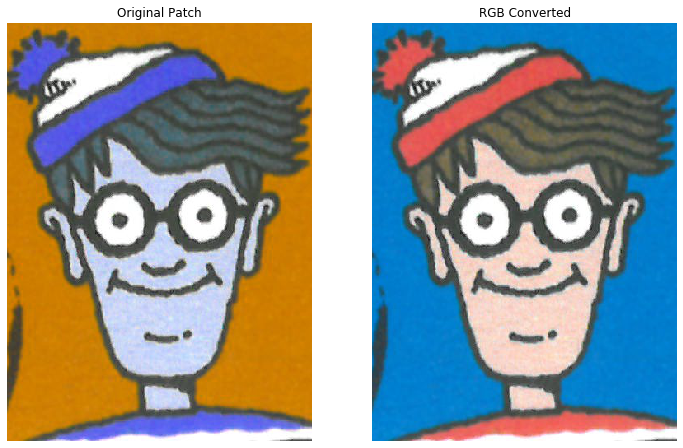

In [6]:
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.subplot(1,2,1)
plt.imshow(train_pos[0])
plt.axis('off')
plt.title('Original Patch')

# Convert to RGB
train_pos = [to_rgb(x) for x in train_pos]
train_neg = [to_rgb(x) for x in train_neg]
val_pos = [to_rgb(x) for x in val_pos]
val_neg = [to_rgb(x) for x in val_neg]

plt.subplot(1,2,2)
plt.imshow(train_pos[0])
plt.axis('off')
plt.title('RGB Converted')

In [7]:
# Extract feature descriptors from training set
positive_features = extract_features(train_pos)
negative_features = extract_features(train_neg)

In [8]:
# Cluster the keypoints to obtain features
train_features = np.vstack((positive_features, negative_features))
print('Number of KAZE descriptors:', len(train_features))
bag_of_words = cluster_features(train_features) # Default number of clusters is 50

Number of KAZE descriptors: 25067


In [9]:
# Extract histogram vectors for each of the training patches
train_images = np.concatenate((train_pos, train_neg), axis=0)
positive_labels = np.ones(len(train_pos))
negative_labels = np.zeros(len(train_neg))
train_labels = np.concatenate((positive_labels, negative_labels), axis=0)

In [10]:
train_histograms = extract_histograms(train_images, bag_of_words)
train_histograms, train_labels = shuffle(train_histograms, train_labels)

### Train Classifier

After extracting the Bag Of Words from the training patches, we then train our classifer on the histogram vector features from training data patches, and test it on our validation patches

In [11]:
# Initialize the validation set
val_images = np.concatenate((val_pos, val_neg), axis=0)
positive_labels = np.ones(len(val_pos))
negative_labels = np.zeros(len(val_neg))
val_labels = np.concatenate((positive_labels, negative_labels), axis=0)
print('Number of validation examples: ', len(val_images))

Number of validation examples:  225


In [12]:
val_histograms = extract_histograms(val_images, bag_of_words)
val_histograms, val_labels = shuffle(val_histograms, val_labels)

In [44]:
# Initialize classification model
# SVM Model
svm = SVC(kernel='linear', C=0.04)
svm.fit(train_histograms, train_labels)

SVC(C=0.04, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [45]:
val_predict = svm.predict(val_histograms)
precision = sk_metrics.precision_score(y_true=val_labels, y_pred=val_predict)
recall = sk_metrics.recall_score(y_true=val_labels, y_pred=val_predict)
f1_score = sk_metrics.f1_score(y_true=val_labels, y_pred=val_predict)
print('Precision: %.3f\nRecall: %.3f\nF1 Score: %.3f' % (precision, recall, f1_score))

Precision: 0.778
Recall: 0.359
F1 Score: 0.491


In [30]:
# XGBoost Model
# NOTE: XGB requires heavy tuning 
xgb = xgboost.XGBClassifier(learning_rate=0.001, n_estimators=250, max_depth=5)
xgb.fit(train_histograms, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=250, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [31]:
val_predict = xgb.predict(val_histograms)
precision = sk_metrics.precision_score(y_true=val_labels, y_pred=val_predict)
recall = sk_metrics.recall_score(y_true=val_labels, y_pred=val_predict)
f1_score = sk_metrics.f1_score(y_true=val_labels, y_pred=val_predict)
print('Precision: %.3f\nRecall: %.3f\nF1 Score: %.3f' % (precision, recall, f1_score))

Precision: 0.517
Recall: 0.795
F1 Score: 0.626


In [17]:
# Random Forest Model
rf = RandomForestClassifier()
rf.fit(train_histograms, train_labels)

/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
val_predict = rf.predict(val_histograms)
precision = sk_metrics.precision_score(y_true=val_labels, y_pred=val_predict)
recall = sk_metrics.recall_score(y_true=val_labels, y_pred=val_predict)
f1_score = sk_metrics.f1_score(y_true=val_labels, y_pred=val_predict)
print('Precision: %.3f\nRecall: %.3f\nF1 Score: %.3f' % (precision, recall, f1_score))

Precision: 0.568
Recall: 0.641
F1 Score: 0.602


### Sliding Window Scoring

We now use our trained classifer to score each window, and threshold windows that have scores beyond a certain benchmark

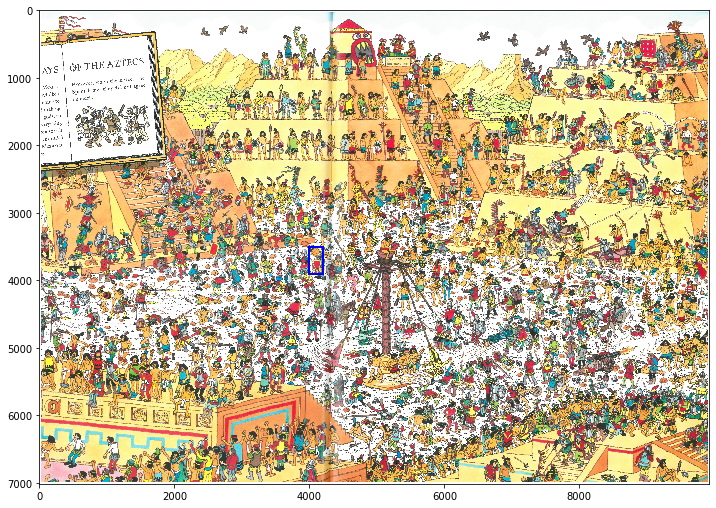

In [19]:
# Visualise window on training image
plt.rcParams['figure.figsize'] = (12.0, 12.0)
fig, ax = plt.subplots(1)

window_size = (200, 400)
step_size = 500

example_full = plt.imread(example_full_path)
ax.imshow(example_full)

rect = patches.Rectangle((4000, 3500), window_size[0], window_size[1], linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

plt.show()

In [20]:
# Perform detection
detections = detect(example_full, bag_of_words, svm)
print('Number of Bounding Boxes: ', len(detections))

Number of Bounding Boxes:  1


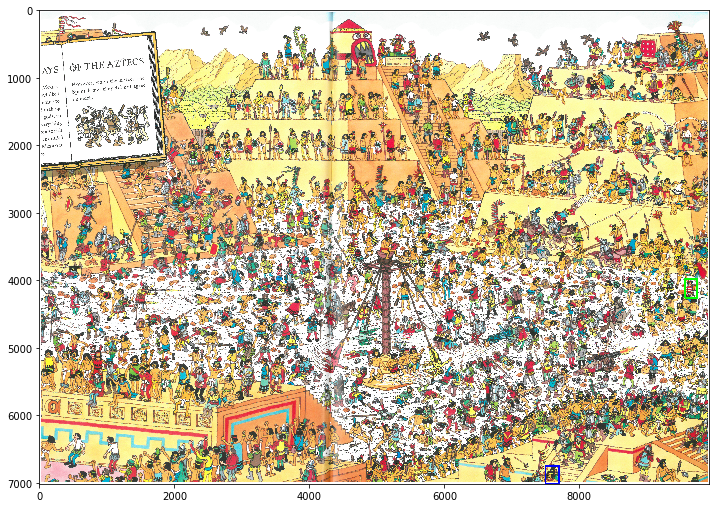

In [21]:
# Visualise detections
ground_truth = train_annots['000']['waldo']
clone = example_full.copy()
for (x1, y1, x2, y2) in detections:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)